In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, balanced_accuracy_score, average_precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



## Lecture du fichier

In [19]:
with open("kddcup.names", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Ignorer la première ligne (qui contient les classes d'attaques)
lines = lines[1:]

# Extraire uniquement les noms des colonnes avant les `:` et supprimer les espaces
columns = [line.split(":")[0].strip() for line in lines]

# Ajouter la colonne cible "label" (classification)
columns.append("label")

# Charger le fichier de données avec les colonnes extraites
data = pd.read_csv("kddcup.data.corrected", sep=",", header=None, names=columns)


In [3]:
data = data.iloc[:489843]

# Séparer les caractéristiques et la cible
X = data.drop('label', axis=1)
Y = data['label']

# Appliquer One-Hot Encoding sur les colonnes catégorielles
X_encoded = pd.get_dummies(X)

# Afficher les premières lignes du dataset après One-Hot Encoding
print(X_encoded.head())

# Appliquer Isolation Forest sur les données encodées
IF = IsolationForest(n_estimators=100, contamination=0.002, random_state=1, n_jobs=-1)
outliers_if = IF.fit_predict(X_encoded)


   duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0         0        215      45076     0               0       0    0   
1         0        162       4528     0               0       0    0   
2         0        236       1228     0               0       0    0   
3         0        233       2032     0               0       0    0   
4         0        239        486     0               0       0    0   

   num_failed_logins  logged_in  num_compromised  ...  flag_REJ  flag_RSTO  \
0                  0          1                0  ...     False      False   
1                  0          1                0  ...     False      False   
2                  0          1                0  ...     False      False   
3                  0          1                0  ...     False      False   
4                  0          1                0  ...     False      False   

   flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  \
0        False      Fals

In [4]:

# Vérifier les dimensions avant encodage
X = data.drop('label', axis=1)
Y = data['label']

print(f"Avant encodage - X.shape: {X.shape}")
print(f"Avant encodage - Y.shape: {Y.shape}")

# Appliquer One-Hot Encoding sur les colonnes catégorielles
X_encoded = pd.get_dummies(X)

# Vérifier les dimensions après encodage
print(f"Après encodage - X_encoded.shape: {X_encoded.shape}")




Avant encodage - X.shape: (489843, 41)
Avant encodage - Y.shape: (489843,)
Après encodage - X_encoded.shape: (489843, 114)


In [ ]:

# Encoder Y avec 'normal' = 0 et les autres labels = 1
Y_encoded = data['label'].replace({'normal.': 0}).apply(lambda x: 0 if x == 0 else 1)


<h1 style="color:blue;">Approches supervisées</h1>

In [6]:
models={'LR' : LogisticRegression(random_state=1),
        'LR_Norm' : LogisticRegression(random_state=1),
       'RF' : RandomForestClassifier(n_estimators=50, random_state = 1, n_jobs=-1)}

In [7]:
def scoring(Ytest,Pred,Prob):
    ba=balanced_accuracy_score(Ytest,Pred)
    f1=f1_score(Ytest,Pred)
    ap=average_precision_score(Ytest,Prob)
    print('Matrice de confusion') 
    print(confusion_matrix(Ytest,Pred))
    print('Balanced Accuracy : %.3f' %ba)    
    print('F1 Score : %.3f' %f1)
    print('Average precision score : %.3f' %ap)
    return ba,f1,ap
        

In [8]:
def original_approach(Xtrain,Ytrain,Xtest,Ytest,model):
    model.fit(Xtrain,Ytrain)
    Pred=model.predict(Xtest)
    Prob=model.predict_proba(Xtest)[:,1]

    best_f1 = f1_score(Ytest,Pred)
    best_pred = Pred

    for i in np.arange(1.0, 0.0, -0.01):
        Pred_LR_new=Prob>=i
        test_f1 = f1_score(Ytest,Pred_LR_new)
        if test_f1 > best_f1 :
            best_f1 = test_f1
            best_pred = Pred_LR_new

    
    return best_pred, Prob

In [9]:
def Tomek(X,Y):
    tl = TomekLinks(n_jobs=-1)
    X_tomek, y_Tomek = tl.fit_resample(X, Y)
    return X_tomek, y_Tomek


In [10]:
def undersampling_approach(Xtrain,Ytrain,Xtest,Ytest,model):
    X_under, Y_under=Tomek(Xtrain,Ytrain)
    Pred, Prob=original_approach(X_under, Y_under,Xtest,Ytest,model)
    return Pred, Prob

In [11]:
def Smote(X,Y):
    sm=SMOTE(k_neighbors=5,random_state=1)
    X_smote, y_smote = sm.fit_resample(X, Y)
    return X_smote, y_smote

In [12]:
def oversampling_approach(Xtrain,Ytrain,Xtest,Ytest,model):
    X_over, Y_over=Smote(Xtrain,Ytrain)
    Pred, Prob=original_approach(X_over, Y_over,Xtest,Ytest,model)
    return Pred, Prob

In [13]:
def balancing_approach(Xtrain,Ytrain,Xtest,Ytest,model):
    cloned_model = clone(model)
    cloned_model.class_weight='balanced'
    Pred, Prob=original_approach(Xtrain,Ytrain,Xtest,Ytest,cloned_model)
    return Pred, Prob

In [14]:
def isolation_forest(Xtrain,Ytrain,Xtest):
    IF = IsolationForest(n_estimators=1000, random_state=1,n_jobs=-1)
    IF.fit(Xtrain)
    Prob=-IF.decision_function(Xtest)
    return Prob

In [15]:
def LOF_novelty(Xtrain,Ytrain,Xtest):
    LOF=LocalOutlierFactor(n_neighbors=200, n_jobs=-1, novelty=True)
    print(Xtrain)
    LOF.fit(Xtrain[Ytrain==0])
    Prob=-LOF.decision_function(Xtest)
    return Prob

In [16]:


def comparaison(Xtrain_1, Xtest_1, Ytrain, Ytest, models):
    
    # Initialisation des variables
    best_model = None
    best_score = 0

    fig, ax = plt.subplots()

    # Étape 1 : LOF et Isolation Forest
    print("Local Outlier Factor : Détection de nouveautés")
    Prob = LOF_novelty(Xtrain_1, Ytrain, Xtest_1)
    PrecisionRecallDisplay.from_predictions(Ytest, Prob, name='LOF_novelty', ax=ax)

    print("Isolation Forest : Détection d'outliers")
    Prob = isolation_forest(Xtrain_1, Ytrain, Xtest_1)
    PrecisionRecallDisplay.from_predictions(Ytest, Prob, name='IF', ax=ax)
    plt.show()

    # Étape 2 : Test des modèles
    for name, model in models.items():
        
        print(f'***************** {name} *****************')

        # Prétraitement des données
        if name == 'LR_Norm':
            RS = RobustScaler()
            Xtrain = RS.fit_transform(Xtrain_1)
            Xtest = RS.transform(Xtest_1)

            joblib.dump(RS, "scaler.pkl")

        else:
            Xtrain = Xtrain_1
            Xtest = Xtest_1

        # Oversampling et undersampling
        X_under, Y_under = Tomek(Xtrain, Ytrain)
        X_over, Y_over = Smote(Xtrain, Ytrain)

        # Pipeline
        pipe = Pipeline([
            ('scaler', RobustScaler()),
            ('model', model)
        ])

        # Définition des hyperparamètres selon le modèle
        param_grid = {}
        if isinstance(model, LogisticRegression):
            param_grid = {
                'model__C': [0.1, 1, 10],
                'model__solver': ['liblinear', 'saga']
            }
        elif isinstance(model, RandomForestClassifier):
            param_grid = {
                'model__n_estimators': [50, 100, 200],
                'model__max_depth': [None, 10, 20],
                'model__min_samples_split': [2, 5, 10]
            }

        # GridSearch
        if param_grid:
            grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
            grid_search.fit(Xtrain, Ytrain)
            current_model = grid_search.best_estimator_
            current_score = grid_search.best_score_
        else:
            current_model = pipe.fit(Xtrain, Ytrain)
            current_score = current_model.score(Xtest, Ytest)



        # Mise à jour du meilleur modèle
        if current_score > best_score:
            best_score = current_score
            best_model = current_model

        # Affichage des scores et courbes PR
        fig, ax = plt.subplots()
        
        print('****** Original Approach ******')
        Pred, Prob = original_approach(Xtrain, Ytrain, Xtest, Ytest, current_model)
        scoring(Ytest, Pred, Prob)
        PrecisionRecallDisplay.from_predictions(Ytest, Prob, name='Original', ax=ax)

        print('****** Balancing Approach ******')
        Pred, Prob = balancing_approach(Xtrain, Ytrain, Xtest, Ytest, current_model)
        scoring(Ytest, Pred, Prob)
        PrecisionRecallDisplay.from_predictions(Ytest, Prob, name='Balancing', ax=ax)

        print('****** Under Sampling Approach ******')
        Pred, Prob = original_approach(X_under, Y_under, Xtest, Ytest, current_model)
        scoring(Ytest, Pred, Prob)
        PrecisionRecallDisplay.from_predictions(Ytest, Prob, name='Under Sampling', ax=ax)

        plt.show()

    # Étape 6 : Sauvegarde du meilleur modèle
    if best_model:
        print(f"Enregistrement du meilleur modèle avec un score de {best_score}")
        joblib.dump(best_model, 'best_model.pkl')
    else:
        print("Aucun modèle trouvé.")




## test

In [17]:
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X_encoded,Y_encoded,test_size=0.5,stratify=Y_encoded,random_state=1)

Local Outlier Factor : Détection de nouveautés
        duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
215372         0        293        736     0               0       0    0   
45974          0        193       5916     0               0       0    0   
232264         0        232       2226     0               0       0    0   
217802         0        161       4183     0               0       0    0   
35729          0        228       1695     0               0       0    0   
...          ...        ...        ...   ...             ...     ...  ...   
212367         0        299      10127     0               0       0    0   
179756         0        269        255     0               0       0    0   
457163         0       1032          0     0               0       0    0   
205451         0        208       1660     0               0       0    0   
467032         0       1032          0     0               0       0    0   

        num_failed_logins  l

c:\Users\joanz\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Isolation Forest : Détection d'outliers


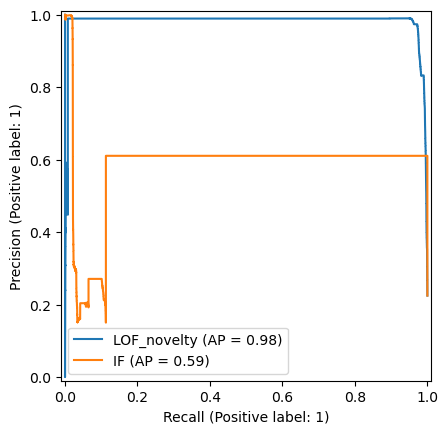

***************** LR *****************


c:\Users\joanz\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


****** Original Approach ******


c:\Users\joanz\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Matrice de confusion
[[189835      0]
 [  2676  52411]]
Balanced Accuracy : 0.976
F1 Score : 0.975
Average precision score : 0.972
****** Balancing Approach ******


c:\Users\joanz\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Matrice de confusion
[[189835      0]
 [  2676  52411]]
Balanced Accuracy : 0.976
F1 Score : 0.975
Average precision score : 0.972
****** Under Sampling Approach ******


c:\Users\joanz\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Matrice de confusion
[[189825     10]
 [  2664  52423]]
Balanced Accuracy : 0.976
F1 Score : 0.975
Average precision score : 0.974


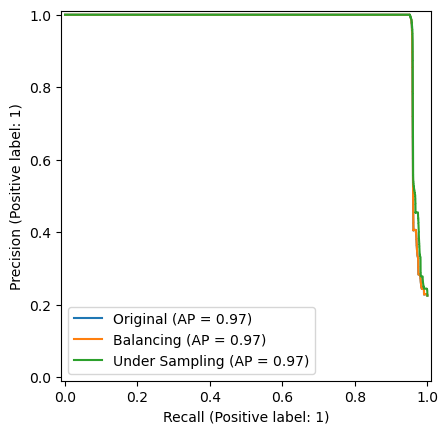

***************** LR_Norm *****************


c:\Users\joanz\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


****** Original Approach ******


c:\Users\joanz\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Matrice de confusion
[[189656    179]
 [  2289  52798]]
Balanced Accuracy : 0.979
F1 Score : 0.977
Average precision score : 0.976
****** Balancing Approach ******


c:\Users\joanz\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Matrice de confusion
[[189656    179]
 [  2289  52798]]
Balanced Accuracy : 0.979
F1 Score : 0.977
Average precision score : 0.976
****** Under Sampling Approach ******


c:\Users\joanz\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Matrice de confusion
[[189824     11]
 [  2664  52423]]
Balanced Accuracy : 0.976
F1 Score : 0.975
Average precision score : 0.974


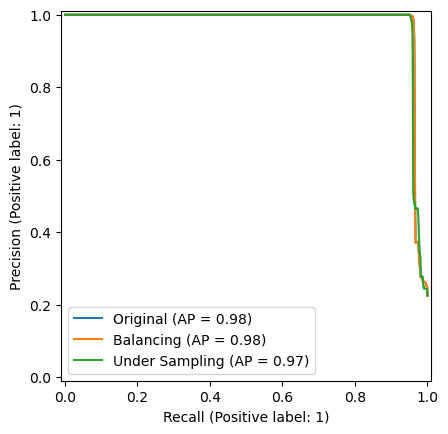

***************** RF *****************
****** Original Approach ******
Matrice de confusion
[[189830      5]
 [     9  55078]]
Balanced Accuracy : 1.000
F1 Score : 1.000
Average precision score : 1.000
****** Balancing Approach ******
Matrice de confusion
[[189830      5]
 [     9  55078]]
Balanced Accuracy : 1.000
F1 Score : 1.000
Average precision score : 1.000
****** Under Sampling Approach ******
Matrice de confusion
[[189830      5]
 [     8  55079]]
Balanced Accuracy : 1.000
F1 Score : 1.000
Average precision score : 1.000


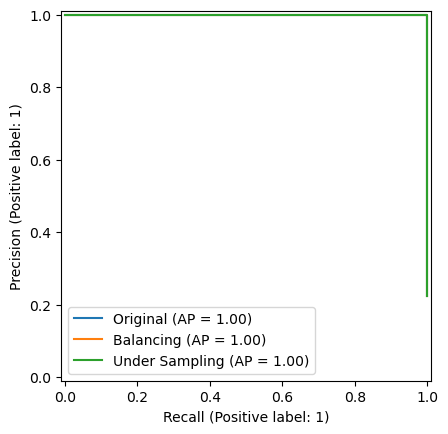

Enregistrement du meilleur modèle avec un score de 0.9999101750009952


In [18]:
comparaison(Xtrain,Xtest,Ytrain,Ytest,models)